# 概要

線形判別分析は、特徴抽出手法の一つである。<br>
PCAはデータセットにおいて分散が最も大きい著効成分軸を見つけ出す。<br>
LDAはクラスの分散を最適化する特徴部分空間を見つけ出す。<br>
<br>
LDAは教師ありアルゴリズムなので、分類タスクの特徴抽出の手段に優れているが、<br>
画像認識の分類結果はPCAの方がよいことがある。<br>
<br>
LDAはデータが正規分布に従っていることが前提となる。<br>
またクラスの共分散行列が全く同じであり特徴量が統計的に見て互いに独立していることも前提となる<br>
この前提は多少満たしていなくても次元削減の手段としてそれなりにうまくいく

# 実装

実装の流れは下記の通り。<br>
1.d次元のデータセットを標準化させる（dは特徴量の個数）<br>
2.クラスごとにd次元の平均ベクトルを計算する<br>
3.クラス間変動行列$S_B$とクラス内変動行列$S_W$を生成する<br>
4.行列$S_W^{-1}S_B$の固有ベクトルと対応する固有値を計算する<br>
5.変換行列を作成する<br>
6.変換行列を使いサンプルを新しい特徴部分空間へ射影する<br>
データセットの標準化は1.PDAで説明したので、平均行列から説明する<br>

### 平均行列を計算する

各平均ベクトル$m_i$にはクラスiのサンプルに関する平均特徴量の値$\mu_m$が格納される<br>
$m_i=\frac{1}{n_i}\sum_{x\in{D_i}}x$<br>
ワインの例では下のようになる<br>
$m_i=\left[
    \begin{array}{cccc}
      \mu_{i,alcohol} \\
      \mu_{i,malic acid} \\
      ・・・\\
      \mu_{i,proline}
    \end{array}
  \right]^T i\in{1,2,3}$


In [13]:
import numpy as np
#有効数字を4桁とする
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



### クラス内変動行列とクラス間変動行列を計算する

平均ベクトルを使ってクラス内変動行列$S_W$を計算する方法は下記になる。<br>
$S_W=\sum^{c}_{i=1}S_i$<br>
$S_i$は下記のように計算される。<br>
$S_i=\sum_{x\in{D_i}}\left(x-m_i\right)\left(x-m_i\right)^T$<br>
<br>
実は、変動行列を求めることは共分散行列$\Sigma_i$の計算と同じになる。<br>
$\Sigma_i=\frac{1}{N_i}S_W$

In [18]:
d = 13  # number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # scatter matrix for each class
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # make column vectors
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sum class scatter matrices

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

#前提条件はクラスラベルが一様に分布していることが前提となるが
#クラスラベルの個数を出力させるとこの前提を満たしていない
print('Class label distribution: %s' 
      % np.bincount(y_train)[1:])

Within-class scatter matrix: 13x13
Class label distribution: [40 49 35]


クラス間変動行列$S_B$の計算は下記の通り<br>
$S_B=\sum^{c}_{i=1}N_i\left(m_i-m\right)\left(m_i-m\right)$<br>
$m$:すべてのクラスのサンプルを対象として計算される全体平均

In [21]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### $S_W^{-1}S_B$の固有ベクトルと固有値を計算する

inv関数で逆行列、dot関数で行列積、eig関数で固有値を計算

In [23]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [24]:
#固有値を大きいものから降順で並び替える
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

10.851109879
3.8430695416
1.75522814207e-15
5.28729014604e-16
5.28729014604e-16
4.26249295868e-16
3.50558009867e-16
3.50558009867e-16
2.34902816549e-16
1.92334784474e-16
1.92334784474e-16
6.20827959986e-17
0.0


ここでクラスラベルの個数をcとすれば、LDAでの線形反d何可能の個数はc-1個となる。<br>
実際にwineではクラスラベル3つなので、固有値は2以外はほぼ0となっている。<br>

PCAの例のように固有値の総和を求める。

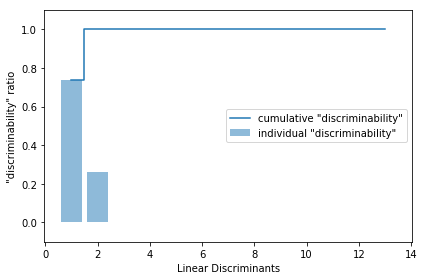

In [26]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/lda1.png', dpi=300)
plt.show()

### 変換行列を作成する

上記より、最初の2つの線形判断でWineトレーニングデート内の有益な情報をほぼ100%補足している。<br>
そこで、2つの線形判断で最も判断力のある2つの固有ベクトルを列方向に並べて変換行列wを作成してみる

In [27]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0758 -0.3623]
 [ 0.0387 -0.2479]
 [-0.0232 -0.3675]
 [ 0.1955  0.2953]
 [-0.0072  0.0233]
 [ 0.2424  0.0108]
 [-0.764   0.2106]
 [-0.082   0.0715]
 [ 0.094   0.1604]
 [ 0.2146 -0.3514]
 [-0.0556  0.2004]
 [-0.3623  0.0437]
 [-0.3398 -0.5862]]


### サンプルを特徴部分空間へ射影する

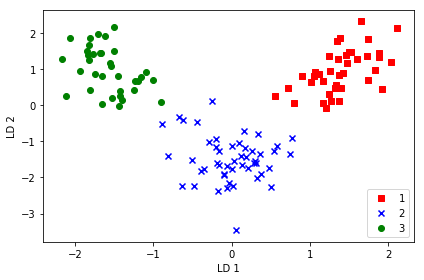

In [29]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0] * (-1),
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('./figures/lda2.png', dpi=300)
plt.show()

# scikit-learnによるLDA

In [31]:
if Version(sklearn_version) < '0.18':
    from sklearn.lda import LDA
else:
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
X_train_lda = lda.fit_transform(X_train_std,y_train)
lda.explained_variance_ratio_

array([ 0.7385,  0.2615])

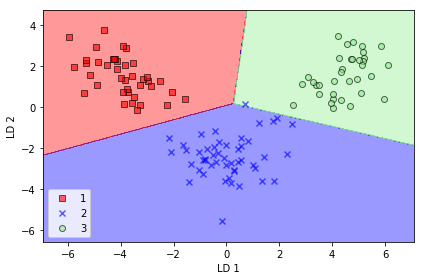

In [34]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda3.png', dpi=300)
plt.show()

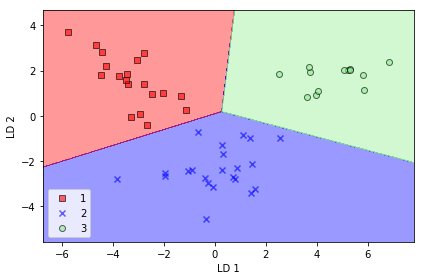

In [35]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./images/lda4.png', dpi=300)
plt.show()

# その他の関数

In [8]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

In [9]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

#Wineデータセットを読み込む
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',\
                     header=None)
#列名を設定
df_wine.columns = ['Class label','Alcohol','Malic acid','Ash',\
                      'Alcalinity of ash','Magnesium','Total phenols','Flavanoids', \
                   'Nonflavanoid phenols','Proanthocyanics','Color intensity','Hue', \
                  'OD280/OD315 of diluted wines','Proline']

#特徴量とクラスラベルを別々に抽出
#sklearn_versionが0.18以上の場合、sklearn_versionは異なる
X,y = df_wine.iloc[:,1:].values,df_wine.iloc[:,0].values
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)



In [11]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [33]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)